In [1]:
from __future__ import print_function, division, unicode_literals
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from AVIReader import * # Reads an avi file and returns a sidpy dataset with meta data
from MonaPathParse import * # Code written to splice files from Mona's experiments, NOT UNIVERSAL 

import os
import sidpy
import sys
import pyNSID
import dask as da
import pandas as pd
import seaborn as sns

In [2]:

filenames = ['Channel_3_30.avi','Channel_3_22_5.avi','Channel_3_15.avi','Channel_3_7_5.avi', \
            'Channel_3_0.avi']
directory = ['8_H','6_H','4_H','2_H','0_H'] #'8_H','6_H',

In [3]:
#After importing the toolboxes above, specify the location of the video file that you want to import and analyze

# Specifies the path location of the experimental video on the hard drive from Mona.
# This path variable will be analyzed to capture metadate about the experiment.
#files = os.listdir("/Volumes/MK_Device_4/Microbial/Good_Final_videos/YR343_030422/YR343_MS_040422/0_H")
#print(files)


dsets = []
ds_titles = []

for i in range (len(filenames)):
    for j in range (len(directory)):
        path = "/Volumes/MK_Device_5/Microbial/8H_Migration_Studies/YR343_030422/YR343_R2A/"+directory[j]+'/' \
        + filenames[i]
        path_dict = MonaPathParse(path)
        path_dict = path_dict.read()
        path_dict['Operator'] = 'Muneeba Khalid'
        path_dict['Objective'] = '20x'
        path_dict['Microscope'] = 'Zeiss Axioscope w/ Phase Contrast'
        path_dict['PhaseSettings'] = 'Y'
        path_dict['Camera'] = 'Infinity3-1UC'
        path_dict['AcquisitionSoftware'] = 'Infinity Capture'
        path_dict['Gain'] = '2'
        path_dict['ExposureTime'] = 'not recorded'
        path_dict['um_per_pixel_scale']  = float(440/687)

        dset = AVIReader(path, path_dict)
        ds = dset.read()
        ds.title = ds.metadata['Species']+'_'+ds.metadata['Media']+\
        '_'+ds.metadata['Timepoint']+ds.metadata['Time_Units']+'_'+ds.metadata['Channel Location']+'mm'
        ds_titles.append(ds.title)
        dsets.append(ds)
        #scale = (dset_read.metadata['um_per_pixel_scale'])
        print(ds.title+' : '+path)

# shows the size and shape of the data set for the imported AVI file
# sidpy.dict_utils.print_nested_dict(dset_read.metadata) #Use this to look at the metadata easily


YR343_R2A_8H_30mm : /Volumes/MK_Device_5/Microbial/8H_Migration_Studies/YR343_030422/YR343_R2A/8_H/Channel_3_30.avi
YR343_R2A_6H_30mm : /Volumes/MK_Device_5/Microbial/8H_Migration_Studies/YR343_030422/YR343_R2A/6_H/Channel_3_30.avi
YR343_R2A_4H_30mm : /Volumes/MK_Device_5/Microbial/8H_Migration_Studies/YR343_030422/YR343_R2A/4_H/Channel_3_30.avi
YR343_R2A_2H_30mm : /Volumes/MK_Device_5/Microbial/8H_Migration_Studies/YR343_030422/YR343_R2A/2_H/Channel_3_30.avi
YR343_R2A_0H_30mm : /Volumes/MK_Device_5/Microbial/8H_Migration_Studies/YR343_030422/YR343_R2A/0_H/Channel_3_30.avi
YR343_R2A_8H_22mm : /Volumes/MK_Device_5/Microbial/8H_Migration_Studies/YR343_030422/YR343_R2A/8_H/Channel_3_22_5.avi
YR343_R2A_6H_22mm : /Volumes/MK_Device_5/Microbial/8H_Migration_Studies/YR343_030422/YR343_R2A/6_H/Channel_3_22_5.avi
YR343_R2A_4H_22mm : /Volumes/MK_Device_5/Microbial/8H_Migration_Studies/YR343_030422/YR343_R2A/4_H/Channel_3_22_5.avi
YR343_R2A_2H_22mm : /Volumes/MK_Device_5/Microbial/8H_Migration_St

In [4]:

mask_vids = []
box_vids = []
max_obj_count = []
min_obj_count = []
average_obj_count = []
object_counts=[]
st_dev_obj_count = []

i=0

for i in range (len(dsets)):

    video = np.array(dsets[i])

    kernelclosing = np.ones((3,3), np.uint8)
    kernel = np.ones((3,3), np.uint8)

    mean_image = np.array(video.mean(axis = 0), dtype='uint8')
    clean_video = np.array((np.divide(video,mean_image)*200), dtype='uint8')

    masks = []
    new_video = []
    object_count = []

    for i in range(video.shape[0]):
        vid = video[i,:,:,:]
    
        frame = clean_video[i,:,:,:]
        roi = frame [0:520,0:696]
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        img_blur = cv2.GaussianBlur(gray, (3,3), 0)
        canny = cv2.Canny(gray, 70, 100)
        closing = cv2.morphologyEx(canny, cv2.MORPH_CLOSE, (kernelclosing))
        #dilation = cv2.dilate(closing, kernel, iterations = 1)
        #opening = cv2.morphologyEx(canny, cv2.MORPH_OPEN, kernel)
    
    
        mask = closing
        masks.append(mask)
        #ret, thresh1 = cv2.threshold(image, 127,255, cv2.THRESH_BINARY)
    
        contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        detections = []
    
        for cnt in contours:
            #calculate the area of the object
            area = cv2.contourArea(cnt)
       
            if area > 2 and area < 40:
            #cv2.drawContours(roi, [cnt], -1, (0,255,0), 2)
                x, y, w, h = cv2.boundingRect(cnt)
                cv2.rectangle(vid, (x-2, y-2), (x + w+2, y + h+2), (0, 255, 0), 1)
                detections.append([x, y, w, h])
        
            if area >=40 and area < 50:
                x, y, w, h = cv2.boundingRect(cnt)
                cv2.rectangle(vid, (x-2, y-2), (x + w+2, y + h+2), (0, 0, 255), 1)
                detections.append([x, y, w, h])
            
        new_video.append(vid)
        object_count.append(len(detections))
    
    max_obj_count.append(max(object_count))
    min_obj_count.append(min(object_count))
    average_obj_count.append(int(sum(object_count)/len(object_count)))
    object_counts.append(object_count)
    st_dev_obj_count.append(np.std(object_count))
#    cv2.imshow("Frame", vid)
#   cv2.imshow("Mask", mask)   
#    key = cv2.waitKey(50)
#    if key == 27:
#        break
   
    box_video = np.stack(new_video, axis = 0)
    mask_video = np.stack(masks, axis=0)
    
    box_vids.append(box_video)
    mask_vids.append(mask_video)

print('Done with analysis')   


Done with analysis


In [5]:
len(mask_vids)
len(box_vids)

25

In [6]:
#Calculate the percent area of a binary image that is white (cell coverage)
area_coverages = []
stdevA = []
i = 0

for i in range (len(mask_vids)):
    j = 0
    binaryImages = mask_vids[i][:,:,:]
    mask_vid_areas = []
    for j in range (binaryImages.shape[0]):
        binaryImage = binaryImages[j,:,:]
        binImage = binaryImage/255
        numW = np.sum(binImage)
        percentArea = int(100*numW/361920)
        mask_vid_areas.append(percentArea)
     
    area_coverages.append(mask_vid_areas)       
    
AverageAreaCovs = []
i = 0
for i in range (len(ds_titles)):
    AveArea = (int(sum(area_coverages[i])/len(area_coverages[i])))
    AverageAreaCovs.append(AveArea)
    stdevA.append(np.std(area_coverages[i]))
print(AverageAreaCovs)
print(stdevA)


[0, 1, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 9, 0, 0, 0, 10, 0, 0, 0, 1, 1, 1, 0, 8]
[0.46508608069787316, 0.0, 0.0, 0.06454915740812345, 0.1762331763605372, 0.0, 0.1288129748731962, 1.8027708226196946, 0.0, 0.0, 0.0, 1.9821030848290633, 2.8301857923624563, 0.0, 0.0, 0.4849256486135633, 2.2054816757793145, 0.0, 0.06428188126485339, 0.1411102029082096, 0.09090593428863095, 0.0, 0.13845885001576144, 0.0, 1.759131804309818]


In [7]:
locations = []
time_points = []

for i in range(len(ds_titles)):
    loc = ds_titles[i].split('_')[3][:-2]
    if loc == '22':
        loc = '22.5'
        
    elif loc == '7':
        loc = '7.5'
   
    locations.append(loc)
    time_points.append(ds_titles[i].split('_')[2])



data = {'Dataset': ds_titles, 'Location':locations, 'Time': time_points,\
     'Min':min_obj_count,'Max':max_obj_count,'Average':average_obj_count, 'StDev_ObjCount':st_dev_obj_count\
       ,'% Area Coverage':AverageAreaCovs,  '%Cov StDev':stdevA}

df = pd.DataFrame(data)


#df.at[(4),'Average']= None
#df.at[(4),'Min']= None
#df.at[(4),'Max']= None
#df.at[(4),'StDev_ObjCount']= None
#df.at[(4),'% Area Coverage']= None
#df.at[(4),'%Cov StDev']= None
    
#df.at[(9),'Average']= None
#df.at[(9),'Min']= None
#df.at[(9),'Max']= None
#df.at[(9),'StDev_ObjCount']= None
#df.at[(9),'% Area Coverage']= None
#df.at[(9),'%Cov StDev']= None

df

,Dataset,Location,Time,Min,Max,Average,StDev_ObjCount,% Area Coverage,%Cov StDev
0,YR343_R2A_8H_30mm,30,8H,37,105,49,9.415802,0,0.465086
1,YR343_R2A_6H_30mm,30,6H,108,141,126,6.561426,1,0.000000
2,YR343_R2A_4H_30mm,30,4H,1,7,3,1.177338,0,0.000000
3,YR343_R2A_2H_30mm,30,2H,0,39,3,5.470192,0,0.064549
4,YR343_R2A_0H_30mm,30,0H,0,49,13,14.795373,0,0.176233
5,YR343_R2A_8H_22mm,22.5,8H,8,55,12,4.055381,0,0.000000
6,YR343_R2A_6H_22mm,22.5,6H,69,122,84,6.922553,0,0.128813
7,YR343_R2A_4H_22mm,22.5,4H,32,101,64,10.803343,3,1.802771
8,YR343_R2A_2H_22mm,22.5,2H,0,39,5,8.500488,0,0.000000
9,YR343_R2A_0H_22mm,22.5,0H,0,39,6,8.719672,0,0.000000


In [8]:
dheat = df.pivot('Location', 'Time', 'Average')
dheat2 = dheat.reindex(['30','22.5','15','7.5','0'])



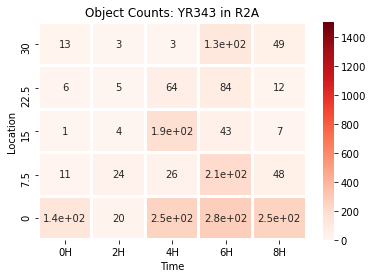

In [9]:
hm = sns.heatmap(dheat2,
                 vmin = 0,
                 vmax = 1500,
                 cmap='Reds',
                 linewidths=2,
                 annot=True)
plt.title('Object Counts: '+dsets[0].metadata['Species']+' in '+dsets[0].metadata['Media'])
plt.savefig("/Volumes/MK_Device_5/FiguresOutput/Count_"+dsets[0].metadata['Species']\
        +'_'+dsets[0].metadata['Media']+'.png', dpi='figure', format='png')

plt.show()